In [5]:
# !pip install keras
# !pip install tensorflow

In [11]:
from multiprocessing import Pool, cpu_count

In [12]:
import keras
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import src.zeldovich as Z

from src.VNET import custom_vnet

%matplotlib inline

In [13]:
# Parameters
Lbox = 256.0  # size of the simulation box
Ngrid = 32  # grid size
# file path of the power spectrum
pkfile = 'colossus_generated_data/pk_indra7313.txt'

# Load power spectrum from txt file
pkinit = np.loadtxt(pkfile)

num_simulations = 5000

In [14]:
# Initialize an empty list to store initial conditions and final states

# Run several simulations and store initial states and final states

def simulation(_):
    ic = np.random.normal(0., 1., (Ngrid, Ngrid, Ngrid))
    final_density, initial_conditions = Z.run_wn(0., ic, pkinit, boxsize=Lbox, ngrid=Ngrid)
    return (initial_conditions, final_density)

with Pool(cpu_count()) as p:
    data = list(tqdm(p.imap(simulation, range(num_simulations), chunksize=1), total=num_simulations))

100%|██████████| 5000/5000 [01:17<00:00, 64.63it/s]


In [15]:
# Convert the list into numpy array for easy data handling
data = np.array(data)

# Split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

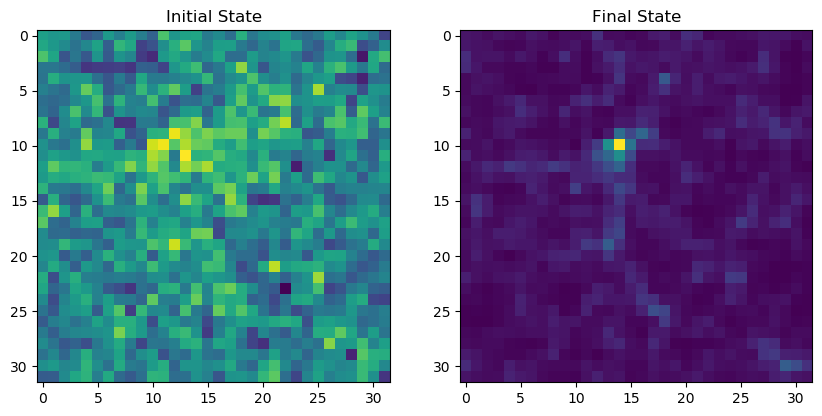

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

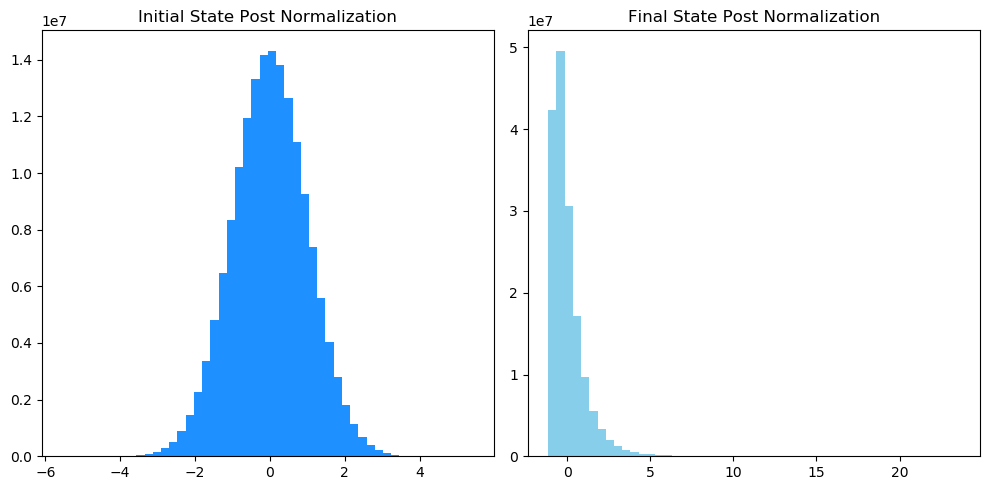

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms
axs[0].hist(initial_state.flatten(), bins=50, color='dodgerblue')
axs[0].set_title('Initial State Post Normalization')
axs[1].hist(final_state.flatten(), bins=50, color='skyblue')
axs[1].set_title('Final State Post Normalization')

plt.tight_layout()
plt.show()

In [18]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.2, random_state=314159)

# further splitting it in training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=314159)

In [19]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

In [20]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((3600, 32, 32, 32, 1),
 (400, 32, 32, 32, 1),
 (3600, 32, 32, 32, 1),
 (400, 32, 32, 32, 1),
 (1000, 32, 32, 32, 1),
 (1000, 32, 32, 32, 1))

In [21]:
# Instantiate VNet model
img_size = (Ngrid, Ngrid, Ngrid, 1)  # image size to use - (size_x, size_y, size_z, num_channels)
vnet = custom_vnet(img_size)

In [22]:
# Compile the model
vnet.compile(optimizer=keras.optimizers.Adam(), 
             loss='mse',
             run_eagerly=True)

In [23]:
history = vnet.fit(x=y_train,
                   y=X_train,
                   validation_data=(y_val, X_val),
                   batch_size=32, 
                   epochs=50)

Epoch 1/50
113/113 [==============================] - 409s 4s/step - loss: 0.8955 - val_loss: 0.8317
Epoch 2/50
113/113 [==============================] - 409s 4s/step - loss: 0.7947 - val_loss: 0.8053
Epoch 3/50
113/113 [==============================] - 406s 4s/step - loss: 0.7583 - val_loss: 0.7515
Epoch 4/50
113/113 [==============================] - 405s 4s/step - loss: 0.7416 - val_loss: 0.7332
Epoch 5/50
113/113 [==============================] - 401s 4s/step - loss: 0.7321 - val_loss: 0.7272
Epoch 6/50
113/113 [==============================] - 406s 4s/step - loss: 0.7251 - val_loss: 0.7183
Epoch 7/50
113/113 [==============================] - 408s 4s/step - loss: 0.7201 - val_loss: 0.7137
Epoch 8/50
113/113 [==============================] - 408s 4s/step - loss: 0.7163 - val_loss: 0.7095
Epoch 9/50
113/113 [==============================] - 407s 4s/step - loss: 0.7131 - val_loss: 0.7056
Epoch 10/50
113/113 [==============================] - 408s 4s/step - loss: 0.7104 - val_lo

In [24]:
eval_results = vnet.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

32/32 [==============================] - 15s 480ms/step - loss: 1.1552
Evaluation Results:1.1551790237426758


In [25]:
predictions = vnet.predict(X_test)
predictions.shape

32/32 [==============================] - 16s 485ms/step


(1000, 32, 32, 32, 1)

In [26]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-5.546975756513235, 5.44006801143435)

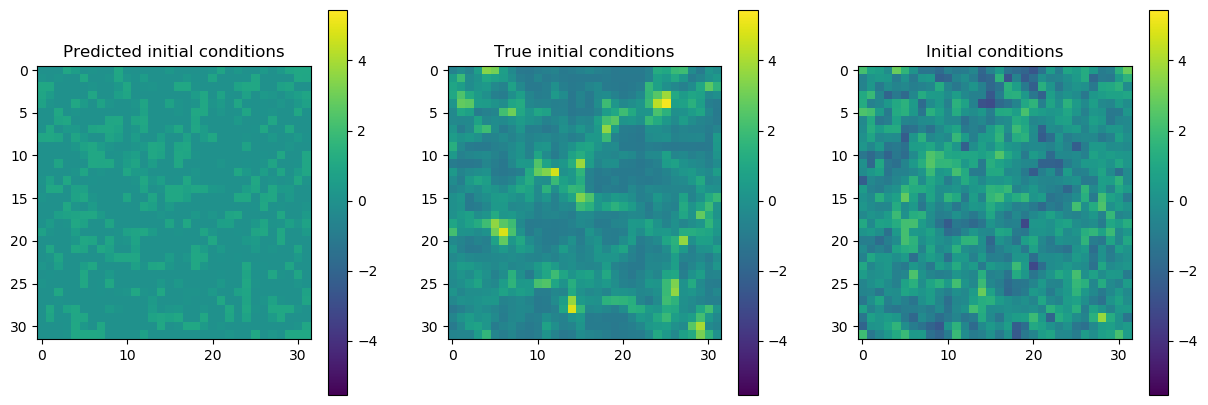

In [27]:
test_index = 0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot predicted initial conditions
im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[0].set_title('Predicted initial conditions')
fig.colorbar(im, ax=axs[0])

# Plot true final conditions
im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[1].set_title('True initial conditions')
fig.colorbar(im, ax=axs[1])

# Plot initial conditions 
im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[2].set_title('Initial conditions')
fig.colorbar(im, ax=axs[2])

plt.show()

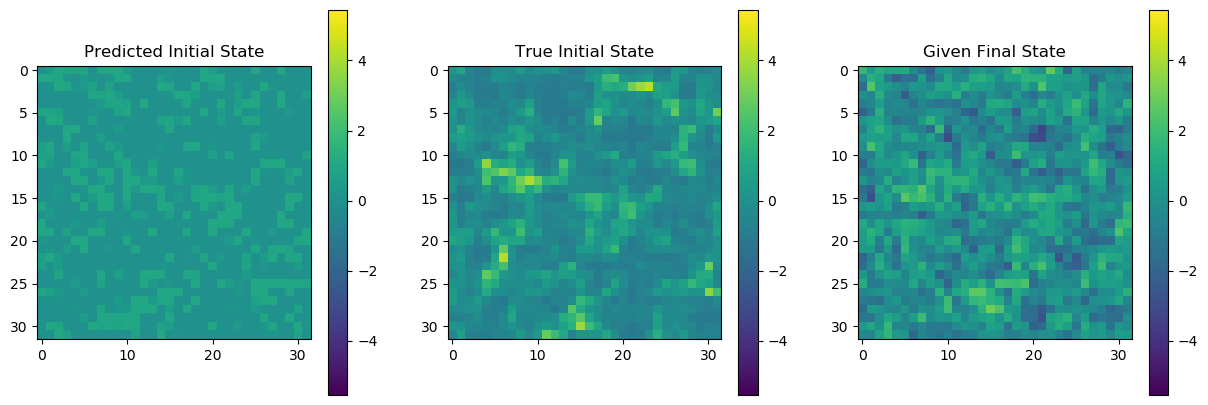

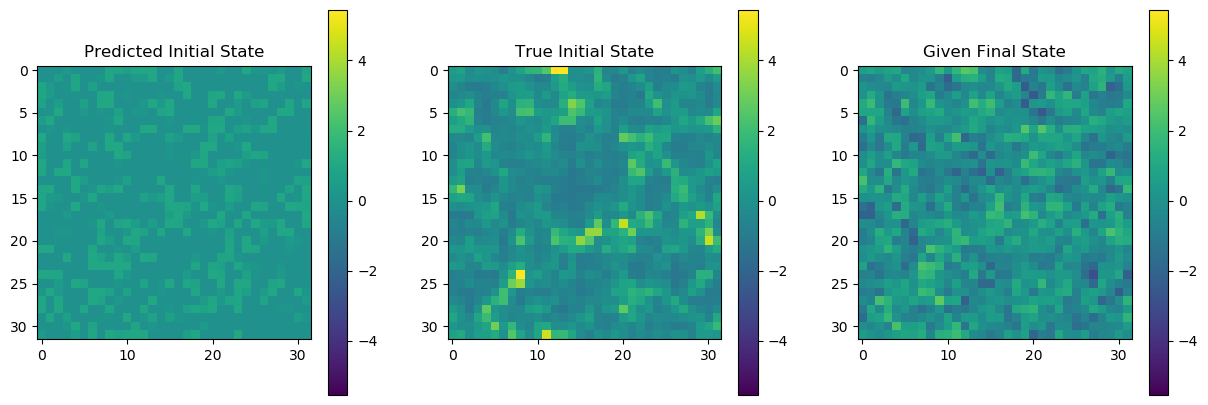

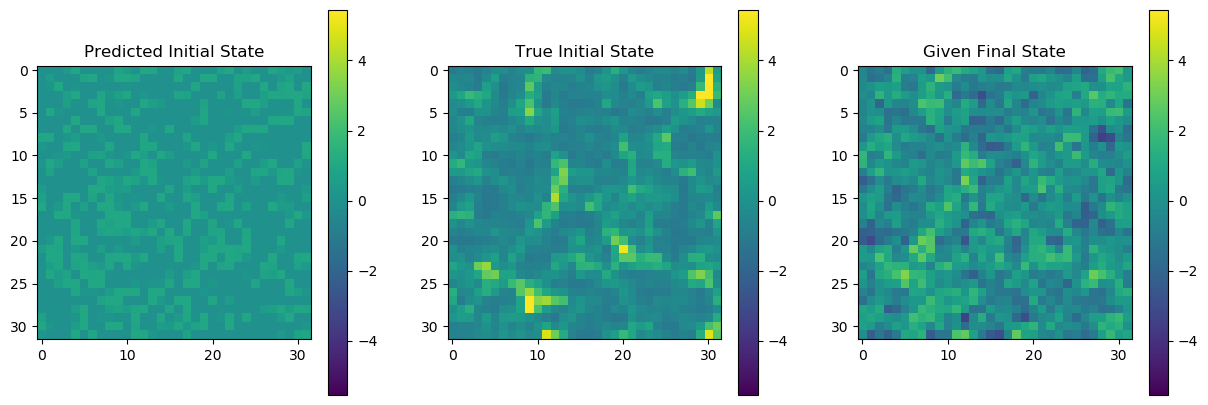

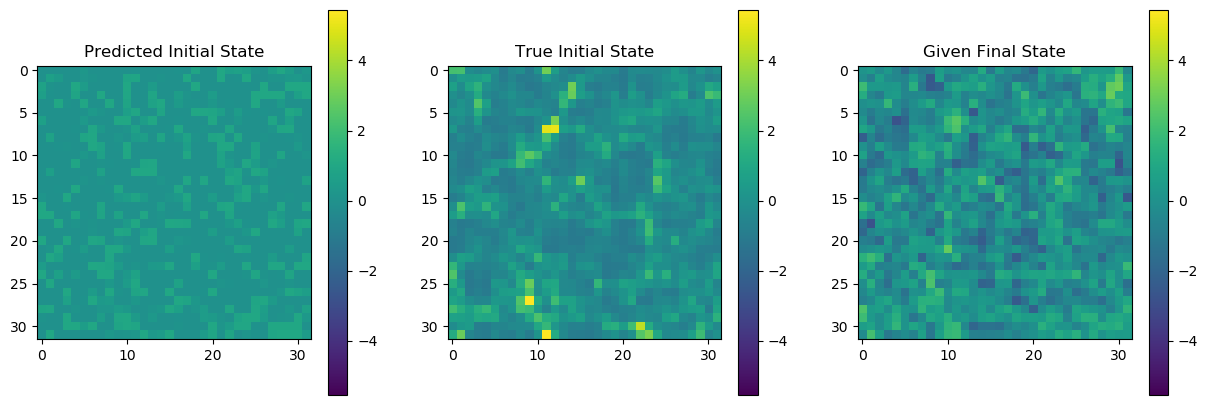

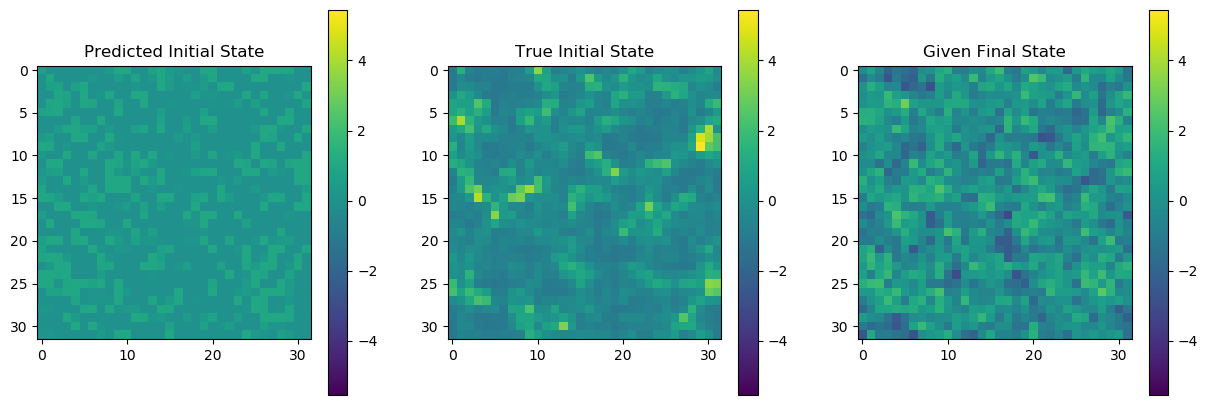

In [28]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [29]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 1.1551790701127531
Mean Absolute Error (MAE): 0.8274735092051034


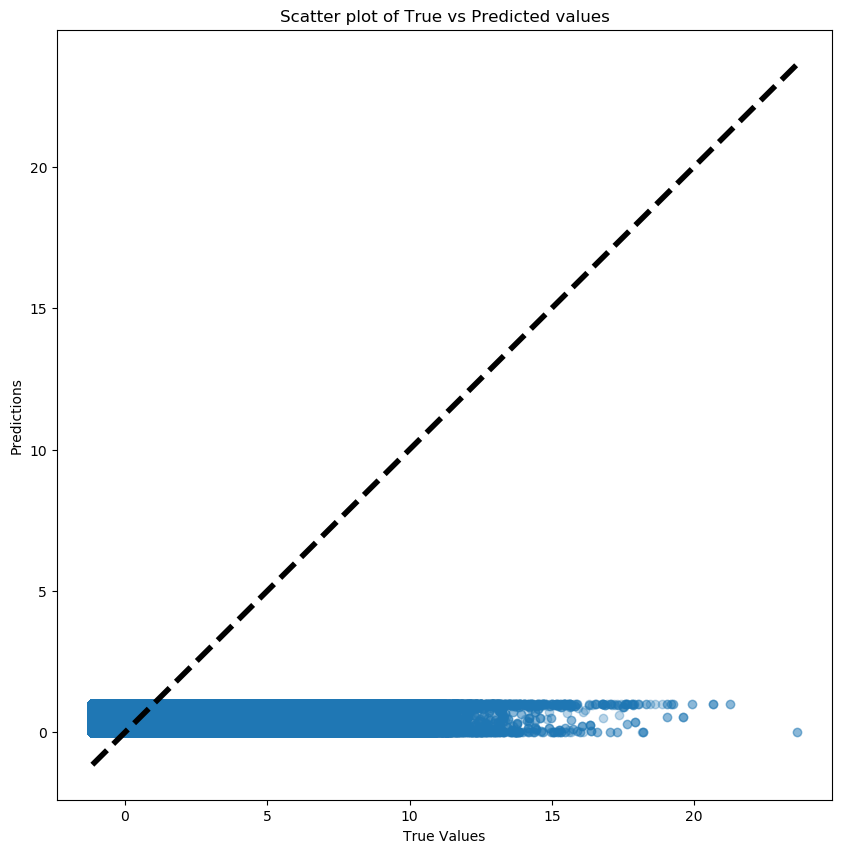

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()